In [90]:
from importlib import reload
import functions
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import pandas as pd
import math
reload(functions)

<module 'functions' from 'c:\\Users\\valta\\Documents\\GitHub\\adaml-ml-project\\functions.py'>

In [91]:
data_path = "household_power_consumption.txt"
df = functions.load_data(data_path)
df_hourly = functions.preprocess_data(df, start_date="17/12/2006", end_date="26/11/2010")

In [92]:
last_year = len(df_hourly) - 24*365

# Split data into training/validation and test sets, last year for testing
train_val_data = df_hourly.iloc[:last_year]
test_data = df_hourly.iloc[last_year:]
nFolds = 5 # using 5 folds for time series cross-validation

tscv = TimeSeriesSplit(n_splits=5, test_size=73*24)

Y = train_val_data["Global_active_power"]
X = train_val_data.loc[:, train_val_data.columns != "Global_active_power"]

folds = []

for i, (train_index, test_index) in enumerate(tscv.split(X, Y)):
    folds.append((train_index, test_index))


In [93]:
folds

[(array([    0,     1,     2, ..., 17037, 17038, 17039], shape=(17040,)),
  array([17040, 17041, 17042, ..., 18789, 18790, 18791], shape=(1752,))),
 (array([    0,     1,     2, ..., 18789, 18790, 18791], shape=(18792,)),
  array([18792, 18793, 18794, ..., 20541, 20542, 20543], shape=(1752,))),
 (array([    0,     1,     2, ..., 20541, 20542, 20543], shape=(20544,)),
  array([20544, 20545, 20546, ..., 22293, 22294, 22295], shape=(1752,))),
 (array([    0,     1,     2, ..., 22293, 22294, 22295], shape=(22296,)),
  array([22296, 22297, 22298, ..., 24045, 24046, 24047], shape=(1752,))),
 (array([    0,     1,     2, ..., 24045, 24046, 24047], shape=(24048,)),
  array([24048, 24049, 24050, ..., 25797, 25798, 25799], shape=(1752,)))]

In [94]:
class EnergyData(Dataset):
    def __init__(self, data, window, target_col="Global_active_power"):
        self.data = data
        self.window = window
        self.target_col = target_col
        
        self.max_index = len(self.data) - self.window - 1

    def __len__(self):
        return max(0, self.max_index)

    def __getitem__(self, index):
        x = self.data.iloc[index:index + self.window].values
        
        y = self.data[self.target_col].iloc[index + self.window]

        x = torch.tensor(x, dtype=torch.float32)
        y = torch.tensor(y, dtype=torch.float32)
        return x, y


In [95]:
window = 24

n = len(train_val_data)
train_size = int(n * 0.8)

In [96]:
train_df = train_val_data.iloc[:train_size]
val_df = train_val_data.iloc[train_size - window:]


In [97]:
train_dataset = EnergyData(train_df, window=window)
val_dataset   = EnergyData(val_df,   window=window)
test_dataset  = EnergyData(test_data, window=window)

In [98]:
batch_size = 64

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_dataset,   batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_dataset,  batch_size=batch_size, shuffle=False)


In [99]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super().__init__()
        pe = torch.zeros(max_len, d_model)                      # (max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float32).unsqueeze(1)
        div_term = torch.exp(
            torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model)
        )

        pe[:, 0::2] = torch.sin(position * div_term)            # parilliset indeksit
        pe[:, 1::2] = torch.cos(position * div_term)            # parittomat indeksit

        pe = pe.unsqueeze(0)                                    # (1, max_len, d_model)
        self.register_buffer("pe", pe)                          # ei ole parametrina, mutta liikkuu devicejen mukana

    def forward(self, x):
        # x: (B, S, d_model)
        seq_len = x.size(1)
        x = x + self.pe[:, :seq_len, :]
        return x


class SimpleTransformer(nn.Module):
    def __init__(
        self,
        num_features,
        d_model=64,
        nhead=4,
        num_layers=2,
        dim_feedforward=24,
        max_len=5000,
    ):
        super().__init__()

        # Projektio feature-tilasta transformer-dimensioon
        self.input_proj = nn.Linear(num_features, d_model)

        # Positionaalinen koodaus
        self.pos_encoder = PositionalEncoding(d_model, max_len=max_len)

        # Encoder-kerrokset
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=dim_feedforward,
            batch_first=True,  # input-muoto: (B, S, D)
        )
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        # Ulostulo: yksi arvo (seuraava tunti)
        self.fc_out = nn.Linear(d_model, 1)

    def forward(self, x):
        # x: (B, S, F) missä F = feature-määrä
        x = self.input_proj(x)          # (B, S, d_model)
        x = self.pos_encoder(x)         # lisätään positionaalinen tieto
        x = self.encoder(x)             # (B, S, d_model)

        # Poolataan aikasuunnassa – keskiarvo koko ikkunasta
        x = x.mean(dim=1)               # (B, d_model)

        out = self.fc_out(x).squeeze(-1)  # (B,)
        return out


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

num_features = train_df.shape[1]  
model = SimpleTransformer(num_features=num_features).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [ ]:
num_epochs = 20

for epoch in range(1, num_epochs + 1):
    model.train()
    train_loss = 0.0

    for xb, yb in train_loader:
        xb = xb.to(device)     # (B, window, F)
        yb = yb.to(device)     # (B,)

        optimizer.zero_grad()
        preds = model(xb)      # (B,)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * xb.size(0)

    train_loss /= len(train_loader.dataset)

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for xb, yb in val_loader:
            xb = xb.to(device)
            yb = yb.to(device)

            preds = model(xb)
            loss = criterion(preds, yb)
            val_loss += loss.item() * xb.size(0)

    val_loss /= len(val_loader.dataset)

    print(f"Epoch {epoch:02d} | Train MSE: {train_loss:.4f} | Val MSE: {val_loss:.4f}")



Epoch 01 | Train MSE: 0.9032 | Val MSE: 0.6544
Epoch 02 | Train MSE: 0.8438 | Val MSE: 0.5464
Epoch 03 | Train MSE: 0.8175 | Val MSE: 0.5152
Epoch 04 | Train MSE: 0.7745 | Val MSE: 0.4734
Epoch 05 | Train MSE: 0.7977 | Val MSE: 0.5929
Epoch 06 | Train MSE: 0.7819 | Val MSE: 0.4564
Epoch 07 | Train MSE: 0.7408 | Val MSE: 0.4280
Epoch 08 | Train MSE: 0.6637 | Val MSE: 0.3573
Epoch 09 | Train MSE: 0.5582 | Val MSE: 0.3552
Epoch 10 | Train MSE: 0.4958 | Val MSE: 0.3596
Epoch 11 | Train MSE: 0.4412 | Val MSE: 0.3166
Epoch 12 | Train MSE: 0.4254 | Val MSE: 0.2741
Epoch 13 | Train MSE: 0.4114 | Val MSE: 0.3236
Epoch 14 | Train MSE: 0.4032 | Val MSE: 0.2629
Epoch 15 | Train MSE: 0.3984 | Val MSE: 0.3070
Epoch 16 | Train MSE: 0.3956 | Val MSE: 0.2709
Epoch 17 | Train MSE: 0.4001 | Val MSE: 0.2689
Epoch 18 | Train MSE: 0.3894 | Val MSE: 0.2592
Epoch 19 | Train MSE: 0.3976 | Val MSE: 0.2678
Epoch 20 | Train MSE: 0.3906 | Val MSE: 0.2668


Test MSE: 0.2948


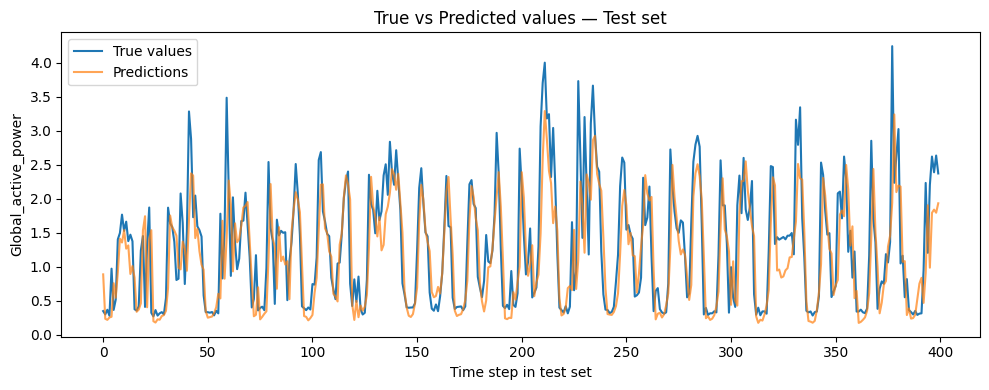

In [102]:
model.eval()
test_loss = 0.0
y_true_list = []
y_pred_list = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        preds = model(X_batch)

        # Collect test loss
        loss = criterion(preds, y_batch)
        test_loss += loss.item() * X_batch.size(0)

        # Collect predictions
        y_true_list.append(y_batch.cpu())
        y_pred_list.append(preds.cpu())

test_loss /= len(test_loader.dataset)
print(f"Test MSE: {test_loss:.4f}")


# Merge into single arrays
y_true = torch.cat(y_true_list).numpy()
y_pred = torch.cat(y_pred_list).numpy()

# Show first 20 predictions vs true values
results_df = pd.DataFrame({
    "True": y_true,
    "Predicted": y_pred
})

n_plot = 400  # Number of time steps to visualize
plt.figure(figsize=(10, 4))
plt.plot(y_true[:n_plot], label="True values")
plt.plot(y_pred[:n_plot], label="Predictions", alpha=0.7)
plt.xlabel("Time step in test set")
plt.ylabel("Global_active_power")
plt.title("True vs Predicted values — Test set")
plt.legend()
plt.tight_layout()
plt.show()
